In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cd drive

In [ ]:
!cd MyDrive

In [ ]:
!cd Colab_Notebooks

In [ ]:
!cd Healthcare

In [ ]:
!git status

In [ ]:
!git add .

In [ ]:
!git commit -m "colab"

In [ ]:
!git pull

Data preprocessing and cleaning

In [762]:
from sklearn.impute import SimpleImputer
import os
import os
import pandas as pd
import numpy as np

np.set_printoptions(suppress=True,   precision=20,  threshold=10,  linewidth=40) # np禁止科学计数法显示
pd.set_option('display.float_format',lambda x : '%.2f' % x) # pd禁止科学计数法显示

In [763]:
path = "data/train_data.csv"

df_all = pd.read_csv(path) # 读取数据，根据你自己文件地址编写

df_all.drop_duplicates(inplace=True) # 使用drop_duplicates去重，inplace=True对原数据集进行替换
df_all.reset_index(drop=True, inplace=True) # 删除数据后，恢复索引

df_all

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.00,31397,7.00,Emergency,Extreme,2,51-60,4911.00,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.00,31397,7.00,Trauma,Extreme,2,51-60,5954.00,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.00,31397,7.00,Trauma,Extreme,2,51-60,4745.00,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.00,31397,7.00,Trauma,Extreme,2,51-60,7272.00,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.00,31397,7.00,Trauma,Extreme,2,51-60,5558.00,41-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318433,318434,6,a,6,X,3,radiotherapy,Q,F,4.00,86499,23.00,Emergency,Moderate,3,41-50,4144.00,11-20
318434,318435,24,a,1,X,2,anesthesia,Q,E,4.00,325,8.00,Urgent,Moderate,4,81-90,6699.00,31-40
318435,318436,7,a,4,X,3,gynecology,R,F,4.00,125235,10.00,Emergency,Minor,3,71-80,4235.00,11-20
318436,318437,11,b,2,Y,3,anesthesia,Q,D,3.00,91081,8.00,Trauma,Minor,5,11-20,3761.00,11-20


In [764]:
# 整体查看数据类型 以及缺失情况
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 18 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   case_id                            318438 non-null  int64  
 1   Hospital_code                      318438 non-null  int64  
 2   Hospital_type_code                 318438 non-null  object 
 3   City_Code_Hospital                 318438 non-null  int64  
 4   Hospital_region_code               318438 non-null  object 
 5   Available Extra Rooms in Hospital  318438 non-null  int64  
 6   Department                         318438 non-null  object 
 7   Ward_Type                          318438 non-null  object 
 8   Ward_Facility_Code                 318438 non-null  object 
 9   Bed Grade                          318325 non-null  float64
 10  patientid                          318438 non-null  int64  
 11  City_Code_Patient                  3139

In [765]:
df_all['Hospital_code'] = df_all['Hospital_code'].astype(object)
df_all['City_Code_Hospital'] = df_all['City_Code_Hospital'].astype(object)
df_all['Bed Grade'] = df_all['Bed Grade'].astype(object)
df_all['City_Code_Patient'] = df_all['City_Code_Patient'].astype(object)

In [766]:
# 整体查看数据类型 以及缺失情况
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 18 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   case_id                            318438 non-null  int64  
 1   Hospital_code                      318438 non-null  object 
 2   Hospital_type_code                 318438 non-null  object 
 3   City_Code_Hospital                 318438 non-null  object 
 4   Hospital_region_code               318438 non-null  object 
 5   Available Extra Rooms in Hospital  318438 non-null  int64  
 6   Department                         318438 non-null  object 
 7   Ward_Type                          318438 non-null  object 
 8   Ward_Facility_Code                 318438 non-null  object 
 9   Bed Grade                          318325 non-null  object 
 10  patientid                          318438 non-null  int64  
 11  City_Code_Patient                  3139

In [767]:
# 定义查找缺失变量函数，返回 缺失值率> 指定缺失率(narate) 的列表
def filter_col_by_nan(data, narate=0.2):
    '''
    :param data: 查找数据集
    :param narate: 设定变量的缺失值率，默认20%
    :return: 返回 缺失率>narate的变量名称列表
    '''
    n_samples = data.shape[0]
    list_nan_cols = []
    for col in data.columns:
        if data[col].isna().sum() / n_samples >= (narate):
            list_nan_cols.append(col)

    print(f'缺失量在{narate * 100}%以上的变量有:{list_nan_cols}')

    return list_nan_cols

list_nullfactor_todrop = filter_col_by_nan(df_all, narate=0.2)

df_select = df_all.drop(list_nullfactor_todrop, axis=1).copy()
df_select

缺失量在20.0%以上的变量有:[]


,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.00,31397,7.00,Emergency,Extreme,2,51-60,4911.00,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.00,31397,7.00,Trauma,Extreme,2,51-60,5954.00,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.00,31397,7.00,Trauma,Extreme,2,51-60,4745.00,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.00,31397,7.00,Trauma,Extreme,2,51-60,7272.00,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.00,31397,7.00,Trauma,Extreme,2,51-60,5558.00,41-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318433,318434,6,a,6,X,3,radiotherapy,Q,F,4.00,86499,23.00,Emergency,Moderate,3,41-50,4144.00,11-20
318434,318435,24,a,1,X,2,anesthesia,Q,E,4.00,325,8.00,Urgent,Moderate,4,81-90,6699.00,31-40
318435,318436,7,a,4,X,3,gynecology,R,F,4.00,125235,10.00,Emergency,Minor,3,71-80,4235.00,11-20
318436,318437,11,b,2,Y,3,anesthesia,Q,D,3.00,91081,8.00,Trauma,Minor,5,11-20,3761.00,11-20


In [768]:
list_factor_todrop = ['case_id', 'patientid'] #不需要入模的变量列表

df_select.drop(list_factor_todrop, axis=1, inplace=True)

df_select

,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,8,c,3,Z,3,radiotherapy,R,F,2.00,7.00,Emergency,Extreme,2,51-60,4911.00,0-10
1,2,c,5,Z,2,radiotherapy,S,F,2.00,7.00,Trauma,Extreme,2,51-60,5954.00,41-50
2,10,e,1,X,2,anesthesia,S,E,2.00,7.00,Trauma,Extreme,2,51-60,4745.00,31-40
3,26,b,2,Y,2,radiotherapy,R,D,2.00,7.00,Trauma,Extreme,2,51-60,7272.00,41-50
4,26,b,2,Y,2,radiotherapy,S,D,2.00,7.00,Trauma,Extreme,2,51-60,5558.00,41-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318433,6,a,6,X,3,radiotherapy,Q,F,4.00,23.00,Emergency,Moderate,3,41-50,4144.00,11-20
318434,24,a,1,X,2,anesthesia,Q,E,4.00,8.00,Urgent,Moderate,4,81-90,6699.00,31-40
318435,7,a,4,X,3,gynecology,R,F,4.00,10.00,Emergency,Minor,3,71-80,4235.00,11-20
318436,11,b,2,Y,3,anesthesia,Q,D,3.00,8.00,Trauma,Minor,5,11-20,3761.00,11-20


In [769]:
# 定义函数，返回离散型函数变量名列表, 并查看映射值数量情况
def get_objectfac_list(data ,print_value=False):
    lt_discrete = []
    for col in data.columns:
        if str(data[col].dtype) == 'object':
            lt_discrete.append(col)
            if print_value == True:
                print(data[col].value_counts())
                print(f'-' * 50)
    return lt_discrete


#list_discrete = get_objectfac_list(df_select,False)

# 情况3，删除离散型变量，有空值的行
df_select.dropna(axis=0,inplace=True)
df_select.reset_index(drop=True, inplace=True)

df_select

,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,8,c,3,Z,3,radiotherapy,R,F,2.00,7.00,Emergency,Extreme,2,51-60,4911.00,0-10
1,2,c,5,Z,2,radiotherapy,S,F,2.00,7.00,Trauma,Extreme,2,51-60,5954.00,41-50
2,10,e,1,X,2,anesthesia,S,E,2.00,7.00,Trauma,Extreme,2,51-60,4745.00,31-40
3,26,b,2,Y,2,radiotherapy,R,D,2.00,7.00,Trauma,Extreme,2,51-60,7272.00,41-50
4,26,b,2,Y,2,radiotherapy,S,D,2.00,7.00,Trauma,Extreme,2,51-60,5558.00,41-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313788,6,a,6,X,3,radiotherapy,Q,F,4.00,23.00,Emergency,Moderate,3,41-50,4144.00,11-20
313789,24,a,1,X,2,anesthesia,Q,E,4.00,8.00,Urgent,Moderate,4,81-90,6699.00,31-40
313790,7,a,4,X,3,gynecology,R,F,4.00,10.00,Emergency,Minor,3,71-80,4235.00,11-20
313791,11,b,2,Y,3,anesthesia,Q,D,3.00,8.00,Trauma,Minor,5,11-20,3761.00,11-20


In [770]:
# 需要对数据进行划分

# ① 取数值、连续类型的数据
list_train_num = ['Available Extra Rooms in Hospital','Visitors with Patient','Admission_Deposit']

# ②取文本/离散、无需独热编码 类型的数据（类似 住宅类型、就业类型 等字段）
list_train_str = ['Bed Grade','Type of Admission','Type of Admission','Age']

# ③取文本/离散、需 独热编码 类型的数据（类似 教育水平分类 等变量）
list_train_str_needtrf = ['Hospital_code','Hospital_type_code','City_Code_Hospital','Hospital_region_code','Department','Ward_Type','Ward_Facility_Code','City_Code_Patient','Type of Admission','Severity of Illness']

# 查看训练集空值情况（此时只剩数值型空值，其他类型的数据都被处理了）
df_select[df_select.isnull().any(axis=1)].head()
df_select

,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,8,c,3,Z,3,radiotherapy,R,F,2.00,7.00,Emergency,Extreme,2,51-60,4911.00,0-10
1,2,c,5,Z,2,radiotherapy,S,F,2.00,7.00,Trauma,Extreme,2,51-60,5954.00,41-50
2,10,e,1,X,2,anesthesia,S,E,2.00,7.00,Trauma,Extreme,2,51-60,4745.00,31-40
3,26,b,2,Y,2,radiotherapy,R,D,2.00,7.00,Trauma,Extreme,2,51-60,7272.00,41-50
4,26,b,2,Y,2,radiotherapy,S,D,2.00,7.00,Trauma,Extreme,2,51-60,5558.00,41-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313788,6,a,6,X,3,radiotherapy,Q,F,4.00,23.00,Emergency,Moderate,3,41-50,4144.00,11-20
313789,24,a,1,X,2,anesthesia,Q,E,4.00,8.00,Urgent,Moderate,4,81-90,6699.00,31-40
313790,7,a,4,X,3,gynecology,R,F,4.00,10.00,Emergency,Minor,3,71-80,4235.00,11-20
313791,11,b,2,Y,3,anesthesia,Q,D,3.00,8.00,Trauma,Minor,5,11-20,3761.00,11-20


<Figure size 1080x576 with 0 Axes>

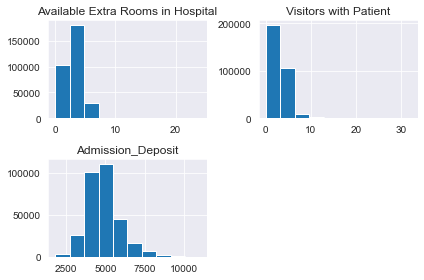

Skewness:


C:\Users\AORUS\AppData\Local\Temp\ipykernel_1388\768500887.py:12: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_select.drop('Stay', axis = 1).skew()


Hospital_code                       -0.28
City_Code_Hospital                   0.54
Available Extra Rooms in Hospital    0.98
Bed Grade                            0.06
City_Code_Patient                    1.58
Visitors with Patient                3.15
Admission_Deposit                    0.93
dtype: float64

In [771]:
# Distribution of numeric independent variables

from matplotlib import pyplot as plt

plt.figure(figsize=(15,8))

df_select.drop('Stay', axis = 1).hist()
plt.tight_layout()
plt.show()

print('Skewness:')
df_select.drop('Stay', axis = 1).skew()

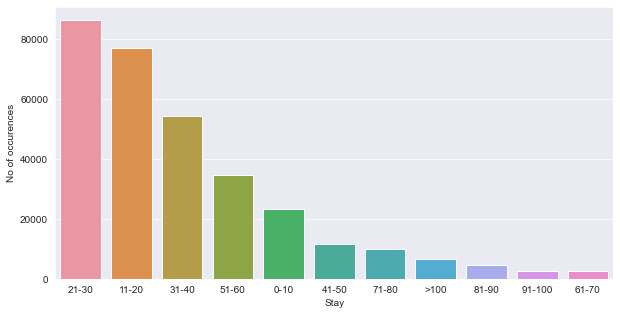

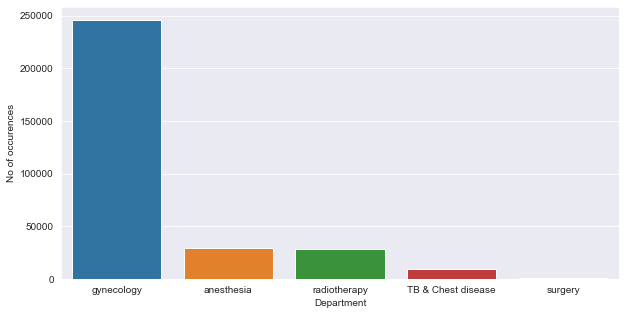

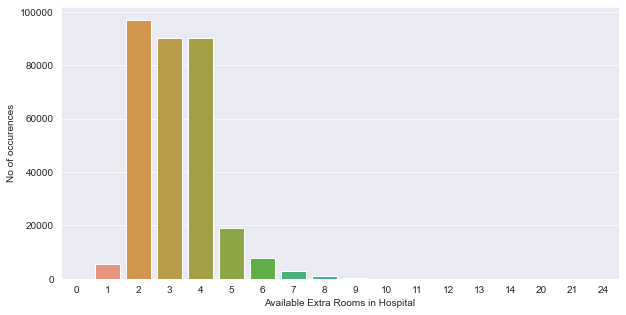

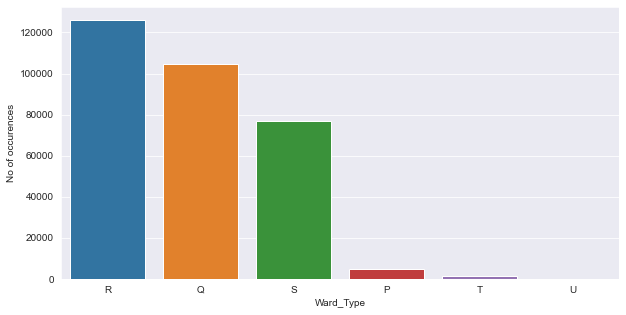

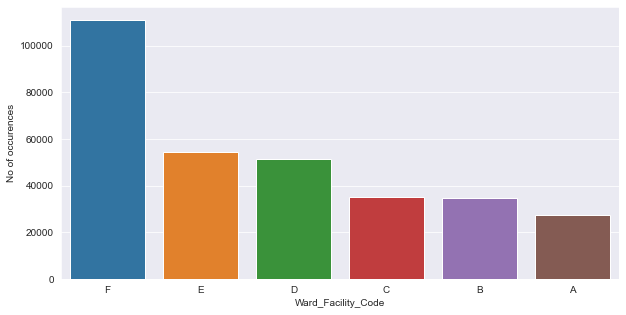

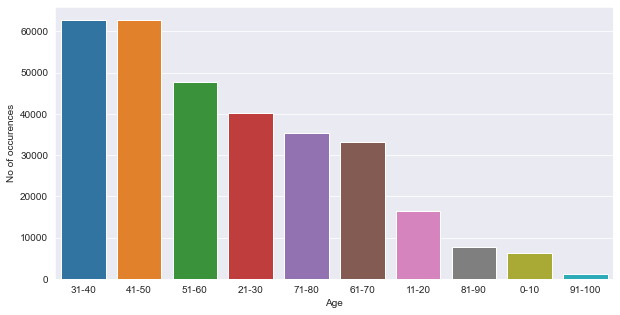

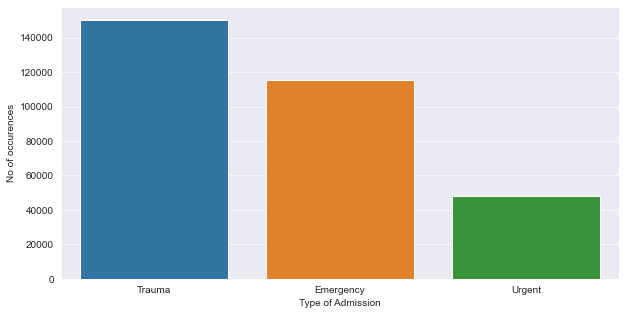

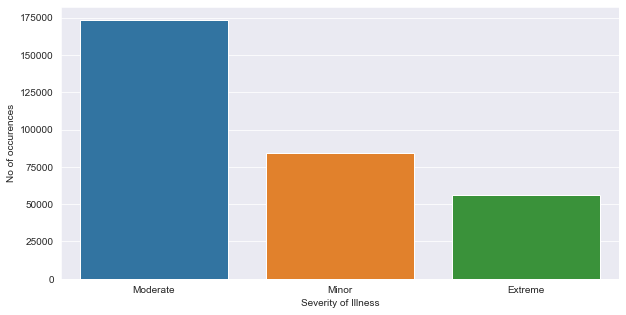

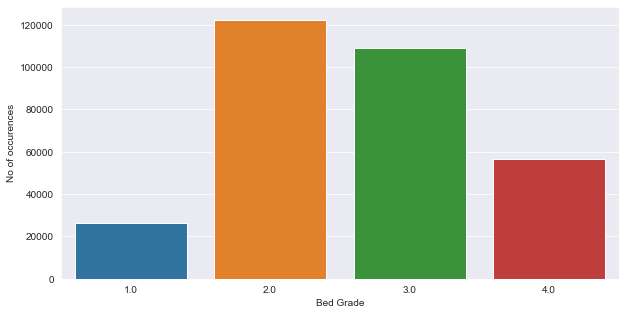

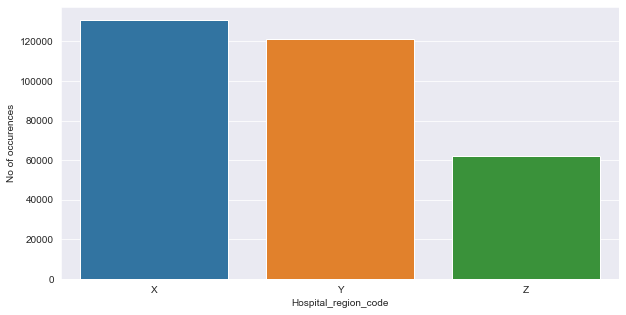

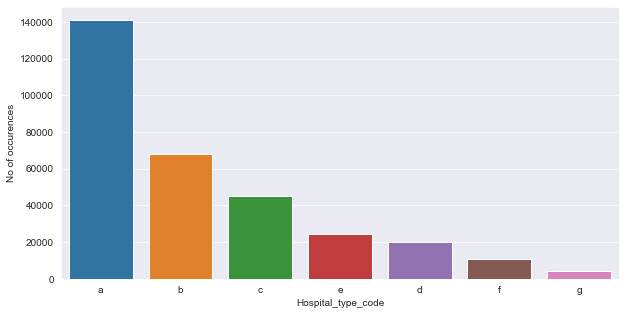

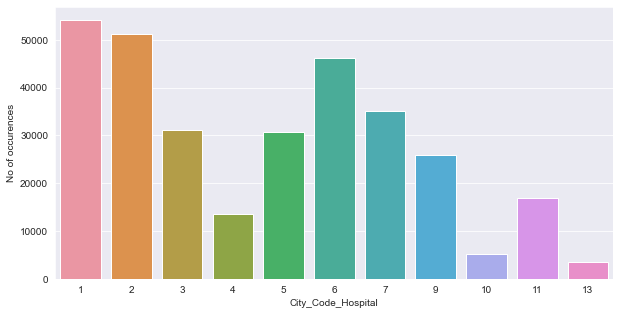

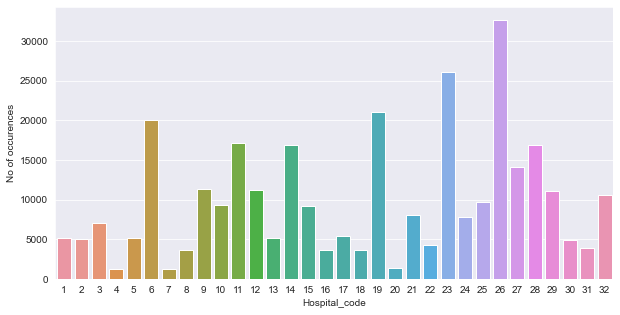

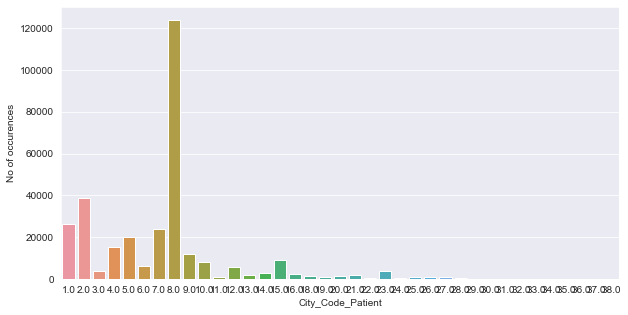

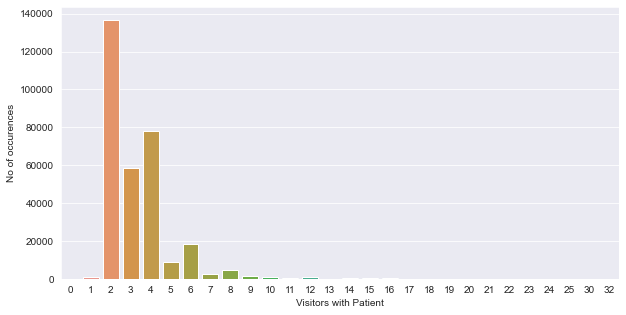

In [772]:
import seaborn as sns

# Univariate Analysis
df_select['Stay'] .replace('More than 100 Days', '>100', inplace=True)

for i in [ 'Stay', 'Department', 'Available Extra Rooms in Hospital', 'Ward_Type' ,'Ward_Facility_Code', 'Age',
          'Type of Admission', 'Severity of Illness', 'Bed Grade', 'Hospital_region_code', 'Hospital_type_code' ,
          'City_Code_Hospital', 'Hospital_code', 'City_Code_Patient', 'Visitors with Patient']:
            count = df_select[i].value_counts()

            plt.figure(figsize=(10,5))

            sns.barplot(x=count.index.values, y=count.values,data=df_select)

            plt.xlabel(i)
            plt.ylabel('No of occurences')

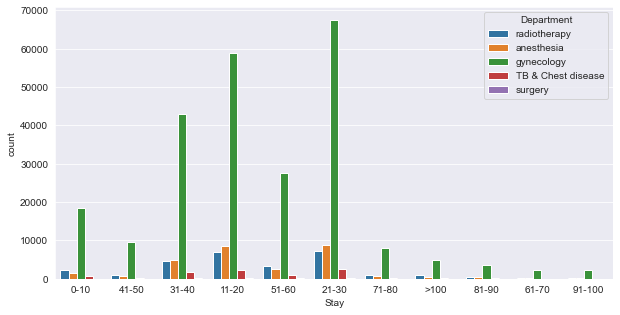

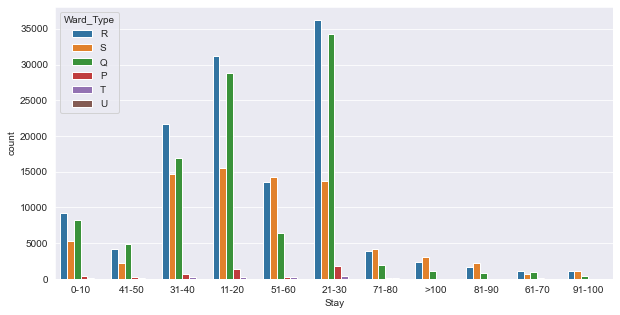

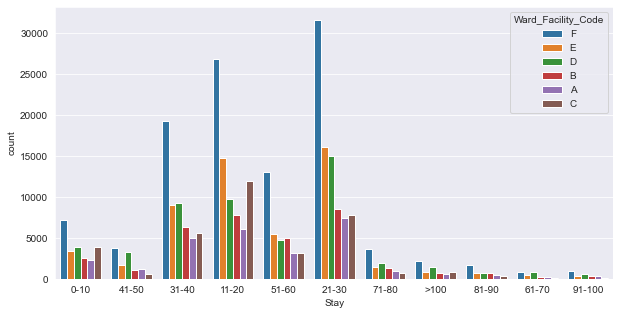

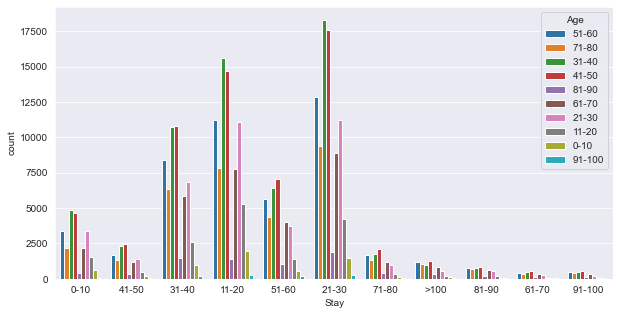

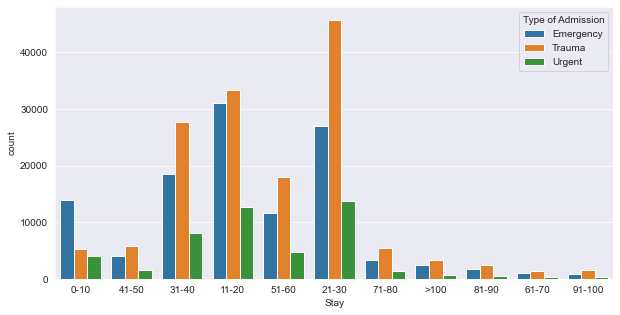

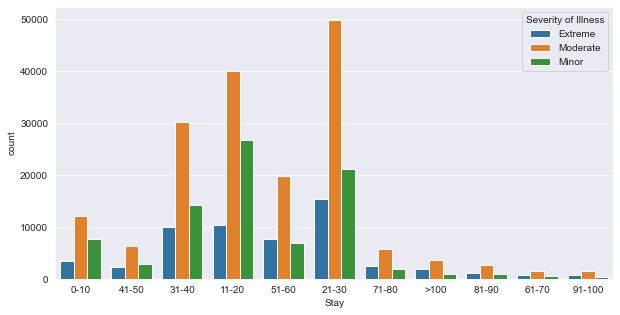

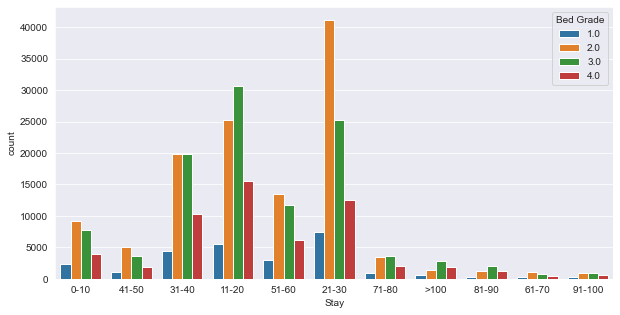

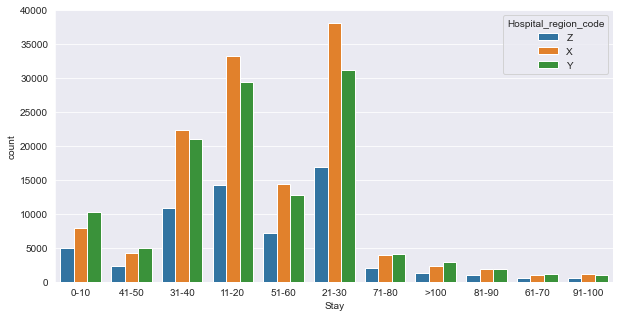

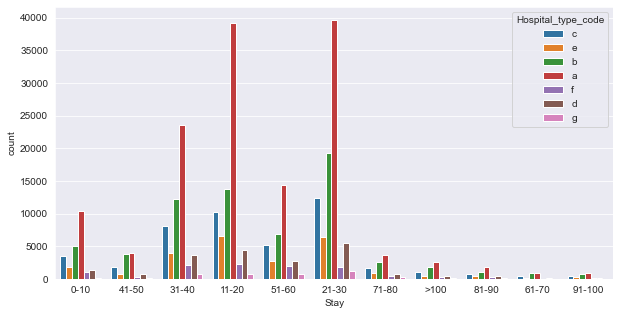

In [773]:
# Bivariate Analysis

for i in [ 'Department', 'Ward_Type' ,'Ward_Facility_Code', 'Age', 'Type of Admission', 'Severity of Illness',
          'Bed Grade', 'Hospital_region_code', 'Hospital_type_code' ]:

            plt.figure(figsize=(10,5))

            sns.countplot(x='Stay',hue=i,data=df_select)

C:\Users\AORUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Admission_Deposit', ylabel='Density'>

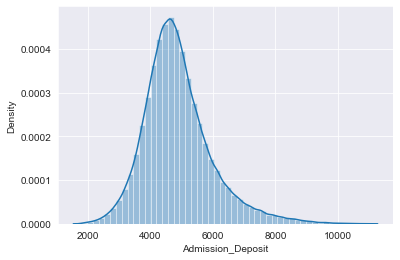

In [774]:
# Numerical Features
sns.distplot( df_select['Admission_Deposit'])



In [775]:
df_num_train = df_select.select_dtypes([np.number])
df_num_train.head()
df_cat_train = df_select.select_dtypes([object])
df_cat_train.head()

,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Department,Ward_Type,Ward_Facility_Code,Bed Grade,City_Code_Patient,Type of Admission,Severity of Illness,Age,Stay
0,8,c,3,Z,radiotherapy,R,F,2.00,7.00,Emergency,Extreme,51-60,0-10
1,2,c,5,Z,radiotherapy,S,F,2.00,7.00,Trauma,Extreme,51-60,41-50
2,10,e,1,X,anesthesia,S,E,2.00,7.00,Trauma,Extreme,51-60,31-40
3,26,b,2,Y,radiotherapy,R,D,2.00,7.00,Trauma,Extreme,51-60,41-50
4,26,b,2,Y,radiotherapy,S,D,2.00,7.00,Trauma,Extreme,51-60,41-50


In [776]:
# df_cat_train['Stay']

In [777]:
# Encoding
admission_encode = {'Trauma': 1, 'Urgent': 2, 'Emergency': 3}
severity_encode = {'Minor': 1, 'Moderate': 2, 'Extreme': 3}

df_cat_train['Type of Admission'] = df_cat_train['Type of Admission'].map(admission_encode)
df_cat_train['Severity of Illness'] = df_cat_train['Severity of Illness'].map(severity_encode)

df_cat_train['Age'] = df_cat_train['Age'].replace(
    {'0-10': 1, '11-20': 2, '21-30': 3, '31-40': 4, '41-50': 5, '51-60': 6, '61-70': 7,
     '71-80': 8, '81-90': 9, '91-100': 10})

df_cat_train['Stay'] = df_cat_train['Stay'].replace(
    {'0-10': 1, '11-20': 2, '21-30': 3, '31-40': 4, '41-50': 5, '51-60': 6, '61-70': 7,
     '71-80': 8, '81-90': 9, '91-100': 10, '>100': 11})

# df_cat_train['Stay'] = df_cat_train['Stay'].astype(int)


In [778]:
from sklearn.preprocessing import LabelEncoder
LE=LabelEncoder()

df_cat_train['Hospital_code']=LE.fit_transform(df_cat_train['Hospital_code'])
df_cat_train['Hospital_type_code']=LE.fit_transform(df_cat_train['Hospital_type_code'])
df_cat_train['City_Code_Hospital']=LE.fit_transform(df_cat_train['City_Code_Hospital'])
df_cat_train['Hospital_region_code']=LE.fit_transform(df_cat_train['Hospital_region_code'])
df_cat_train['Department']=LE.fit_transform(df_cat_train['Department'])
df_cat_train['Ward_Type']=LE.fit_transform(df_cat_train['Ward_Type'])
df_cat_train['Ward_Facility_Code']=LE.fit_transform(df_cat_train['Ward_Facility_Code'])
df_cat_train['City_Code_Patient']=LE.fit_transform(df_cat_train['City_Code_Patient'])
df_cat_train['Bed Grade']=LE.fit_transform(df_cat_train['Bed Grade'])

df_cat_train.head()

,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Department,Ward_Type,Ward_Facility_Code,Bed Grade,City_Code_Patient,Type of Admission,Severity of Illness,Age,Stay
0,7,2,2,2,3,2,5,1,6,3,3,6,1
1,1,2,4,2,3,3,5,1,6,1,3,6,5
2,9,4,0,0,1,3,4,1,6,1,3,6,4
3,25,1,1,1,3,2,3,1,6,1,3,6,5
4,25,1,1,1,3,3,3,1,6,1,3,6,5


In [779]:
from sklearn.preprocessing import StandardScaler
# For training Data
sc = StandardScaler()

num_scaled = sc.fit_transform(df_num_train)
num_scaled

array([[-0.1681784501579786 ,
        -0.7270347126842188 ,
         0.02679589723926186],
       [-1.0244000841390384 ,
        -0.7270347126842188 ,
         0.9869868987865132 ],
       [-1.0244000841390384 ,
        -0.7270347126842188 ,
        -0.12602453061964872],
       ...,
       [-0.1681784501579786 ,
        -0.15941893557879816,
        -0.5955330740416029 ],
       [-0.1681784501579786 ,
         0.9758126186320433 ,
        -1.0318998379278896 ],
       [ 1.544264817804141  ,
        -0.7270347126842188 ,
        -0.11958029570993563]])

In [780]:
df_num_scaled = pd.DataFrame(num_scaled, columns = df_num_train.columns)
df_num_scaled = df_num_scaled.reset_index(drop=True)
df_num_scaled

,Available Extra Rooms in Hospital,Visitors with Patient,Admission_Deposit
0,-0.17,-0.73,0.03
1,-1.02,-0.73,0.99
2,-1.02,-0.73,-0.13
3,-1.02,-0.73,2.20
4,-1.02,-0.73,0.62
...,...,...,...
313788,-0.17,-0.16,-0.68
313789,-1.02,0.41,1.67
313790,-0.17,-0.16,-0.60
313791,-0.17,0.98,-1.03


In [781]:
df_full = pd.concat([df_num_scaled, df_cat_train],axis=1)
df_full.shape


(313793, 16)

<AxesSubplot:>

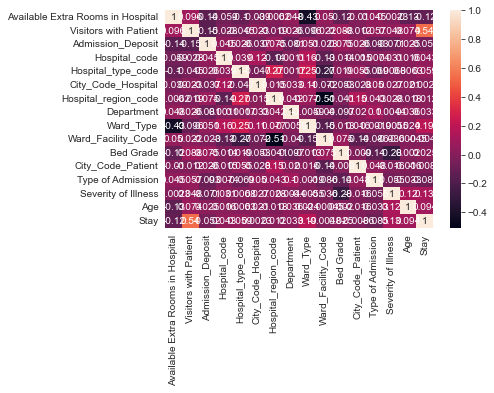

In [782]:
sns.heatmap(df_full.corr(), annot = True)

In [783]:
# 数据清洗函数定义
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import check_array
from scipy import sparse


class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """将分类特征编码为数字数组。
    此函数输入 分类的整数矩阵 或 字符串矩阵,
    将把分类（离散）特征所具有的值转化为数组

    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        # 报错预警
        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape # n_samples 样本数，n_features 特征数

        self._label_encoders_ = [LabelEncoder() for n_f in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape


        X_int = np.zeros_like(X, dtype=np.int) # 构建一个和 X 维度相同的(一毛一样)  整数零矩阵
        X_mask = np.ones_like(X, dtype=np.bool) # 构建一个和 X 维度相同的(一毛一样)   布尔矩阵

        for i in range(n_features): # 对每个变量开始循环
            valid_mask = np.in1d(X[:, i], self.categories_[i]) # 每个变量的每一行，去验证是否是是此变量unqiue中的一个，是返回True

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask # unique矩阵赋予X_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel() # .ravel()将矩阵向量化

        n_values = [cats.shape[0] for cats in self.categories_]

        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask] # 找到该变量某个离散值中的所有的列索引
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]


        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        # out = out[:,1:] # 这里为one_hot,如果要转换成哑变量需要将状态进行k-1删除，防止虚拟陷阱！

        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [784]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [785]:
class ExeLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._stretltype = 1

    def fit(self, X, y=None):
        return self

    def transform(self, X):

        encoder = LabelEncoder()
        n_samples, n_features = X.shape
        arr = np.zeros_like(X, dtype=np.int)

        for whlist in range(X.shape[1]):
            arr[:, whlist] = encoder.fit_transform(X[:, whlist])
        return arr

In [786]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm


In [787]:
X = df_full.drop('Stay',axis=1)
Y = df_full['Stay']

X = sm.add_constant(X)

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, random_state = 10, test_size = 0.3)

Xtrain

,const,Available Extra Rooms in Hospital,Visitors with Patient,Admission_Deposit,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Department,Ward_Type,Ward_Facility_Code,Bed Grade,City_Code_Patient,Type of Admission,Severity of Illness,Age
215421,1.00,1.54,-0.16,-0.60,4,0,0,0,2,2,4,3,6,1,1,8
293528,1.00,-0.17,-0.73,2.52,10,1,1,1,2,3,3,1,16,2,1,5
166481,1.00,-0.17,-0.16,-0.41,25,1,1,1,2,1,3,1,7,2,2,4
46454,1.00,-0.17,0.41,1.06,22,0,5,0,2,1,5,3,1,2,2,5
197625,1.00,0.69,-0.73,-1.28,2,2,2,2,2,2,0,1,8,1,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299741,1.00,1.54,-0.73,-0.64,2,2,2,2,2,2,0,3,4,2,2,6
9372,1.00,0.69,0.41,1.48,10,1,1,1,3,1,3,3,8,1,1,8
105595,1.00,-0.17,-0.73,-0.73,10,1,1,1,2,1,3,2,7,1,3,5
93553,1.00,-0.17,-0.73,-0.75,20,2,2,2,3,2,0,1,0,1,3,3


In [788]:
Xtrain.shape

(219655, 16)

In [789]:
Xtest.shape

(94138, 16)

In [790]:
Ytrain.shape

(219655,)

In [791]:
Ytest.shape

(94138,)

In [792]:
# 利用Pipeline定义不同变量清洗过程
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler # 数据标准化

# 连续型：处理顺序为1.DataFrameSelector 选择数据集，2.SimpleImputer填充缺失值，3.StandardScaler进行标准化数据
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(list_train_num)),
    ('simple_imputer', SimpleImputer(strategy="mean")),# median为中位数，most_frequent为众数。constant表示将空值填充为自定义的值，但这个自定义的值要通过fill_value来定义
    ('std_scaler', StandardScaler()), # 进行标准化
    ])

# 离散，将数据转化为 数字
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(list_train_str)),
    ('label_encoder', ExeLabelEncoder()), # 进行 ExeLabelEncoder
    ])

# 离散，将数据转化为 数字，并进行onehot编码
cat_onehot_pipeline = Pipeline([ # 类别需要onehot编码
    ('selector', DataFrameSelector(list_train_str_needtrf)),
    ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
    ])

Xtrain

,const,Available Extra Rooms in Hospital,Visitors with Patient,Admission_Deposit,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Department,Ward_Type,Ward_Facility_Code,Bed Grade,City_Code_Patient,Type of Admission,Severity of Illness,Age
215421,1.00,1.54,-0.16,-0.60,4,0,0,0,2,2,4,3,6,1,1,8
293528,1.00,-0.17,-0.73,2.52,10,1,1,1,2,3,3,1,16,2,1,5
166481,1.00,-0.17,-0.16,-0.41,25,1,1,1,2,1,3,1,7,2,2,4
46454,1.00,-0.17,0.41,1.06,22,0,5,0,2,1,5,3,1,2,2,5
197625,1.00,0.69,-0.73,-1.28,2,2,2,2,2,2,0,1,8,1,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299741,1.00,1.54,-0.73,-0.64,2,2,2,2,2,2,0,3,4,2,2,6
9372,1.00,0.69,0.41,1.48,10,1,1,1,3,1,3,3,8,1,1,8
105595,1.00,-0.17,-0.73,-0.73,10,1,1,1,2,1,3,2,7,1,3,5
93553,1.00,-0.17,-0.73,-0.75,20,2,2,2,3,2,0,1,0,1,3,3


In [793]:
Ytrain

215421    1
293528    1
166481    3
46454     2
197625    2
         ..
299741    9
9372      4
105595    3
93553     4
236669    3
Name: Stay, Length: 219655, dtype: int64

In [794]:
# K Fold Cross Validation
# from sklearn.model_selection import KFold,cross_val_score
# kfold=KFold(n_splits=10, shuffle=True, random_state=10)


In [795]:
# from sklearn.metrics import accuracy_score
# from sklearn.linear_model import LogisticRegression
#
# LR = LogisticRegression()
#
# LR.fit(Xtrain,Ytrain)
#
# y_pred_LR=LR.predict(Xtest)
# accuracy_score(Ytest,y_pred_LR)*100

In [796]:
# 定义FeatureUnion 进行流水化清洗数据
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
        ("cat_onehot_pipeline",cat_onehot_pipeline)
    ])

df_select_prepared = full_pipeline.fit_transform(Xtrain) # 使用流水线清洗数据，对Xtrain进行etl
df_select_test = full_pipeline.fit_transform(Xtest) # 使用流水线清洗数据，对Xtest进行etl
Ytrain

C:\Users\AORUS\AppData\Local\Temp\ipykernel_1388\332330603.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  arr = np.zeros_like(X, dtype=np.int)
C:\Users\AORUS\AppData\Local\Temp\ipykernel_1388\710887913.py:50: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = check_array(X, dtype=np.ob

215421    1
293528    1
166481    3
46454     2
197625    2
         ..
299741    9
9372      4
105595    3
93553     4
236669    3
Name: Stay, Length: 219655, dtype: int64

In [797]:

df_select_prepared # 查看清洗后的数据维度（行列）

array([[ 1.5474413051804847 ,
        -0.15897699943532037,
        -0.6022203069194277 , ...,
         1.                 ,
         0.                 ,
         0.                 ],
       [-0.16764347637114707,
        -0.727088226776256  ,
         2.510840012088383  , ...,
         1.                 ,
         0.                 ,
         0.                 ],
       [-0.16764347637114707,
        -0.15897699943532037,
        -0.4073092650914135 , ...,
         0.                 ,
         1.                 ,
         0.                 ],
       ...,
       [-0.16764347637114707,
        -0.727088226776256  ,
        -0.7290963624489841 , ...,
         0.                 ,
         0.                 ,
         1.                 ],
       [-0.16764347637114707,
        -0.727088226776256  ,
        -0.7484035882904383 , ...,
         0.                 ,
         0.                 ,
         1.                 ],
       [-1.025185867146963  ,
        -0.727088226776256  

Feature Selection

In [798]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE


In [799]:
# 1.构建RF模型
RFC_ = RFC()                               # 随机森林
c = RFC_.fit(Xtrain, Ytrain).feature_importances_    # 特征重要性
print("重要性：")
c

重要性：


array([0.                 ,
       0.07377469788020381,
       0.09501972213959105, ...,
       0.02675873918084533,
       0.0394131926283189 ,
       0.12651785005128593])

In [800]:

# 2. 交叉验证递归特征消除法
selector = RFECV(RFC_, step=1, cv=10)       # 采用交叉验证，每次排除一个特征，筛选出最优特征
selector = selector.fit(Xtrain, Ytrain)
X_wrapper = selector.transform(Xtrain)          # 最优特征
score =cross_val_score(RFC_ , X_wrapper, Ytrain, cv=10).mean()   # 最优特征分类结果
print(score)
print("最佳数量和排序")
print(selector.support_)                                    # 选取结果
print(selector.n_features_)                                 # 选取特征数量
print(selector.ranking_)                                    # 依次排数特征排序

0.38610548587195337
最佳数量和排序
[False  True  True ...  True  True
  True]
12
[5 1 1 ... 1 1 1]


In [801]:
print(score)
print("最佳数量和排序")
selector.support_                                # 选取结果

0.38610548587195337
最佳数量和排序


array([False,  True,  True, ...,  True,
        True,  True])

In [802]:
# 3.递归特征消除法
selector1 = RFE(RFC_, n_features_to_select=3, step=1).fit(Xtrain, Ytrain)       # n_features_to_select表示筛选最终特征数量，step表示每次排除一个特征
selector1.support_.sum()
print(selector1.ranking_)                                             # 特征排除排序
print(selector1.n_features_)                                          # 选择特征数量
X_wrapper1 = selector1.transform(Xtrain)                                   # 最优特征
score =cross_val_score(RFC_, X_wrapper1, Ytrain, cv=9).mean()
score

[14  4  3 ... 10  9  2]
3


0.21841979672460127

In [803]:
selector1.n_features_                                # 选取特征数量

3

In [804]:
selector1.ranking_

array([14,  4,  3, ..., 10,  9,  2])

In [805]:
selector1.support_

array([False, False, False, ..., False,
       False, False])

0.3114657021670209 7
[0.26841638829789116, 0.2291502536722917, 0.21873393197944824, 0.21986296267169161, 0.2775670764261891, 0.3028112036999169, 0.3114657021670209]


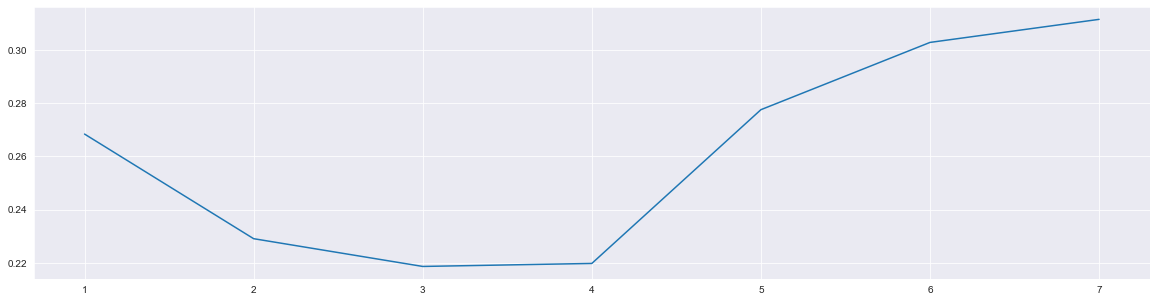

In [806]:

# 4.递归特征消除法和曲线图选取最优特征数量
score = []                                                            # 建立列表
for i in range(1, 17, 1):
    X_wrapper = RFE(RFC_, n_features_to_select=i, step=1).fit_transform(Xtrain, Ytrain)    # 最优特征
    once = cross_val_score(RFC_, X_wrapper, Ytrain, cv=9).mean()                      # 交叉验证
    score.append(once)                                                           # 交叉验证结果保存到列表
print(max(score), (score.index(max(score))*1)+1)                                 # 输出最优分类结果和对应的特征数量
print(score)
plt.figure(figsize=[20, 5])
plt.plot(range(1, 17, 1), score)
plt.xticks(range(1, 17, 1))
plt.show()

In [807]:
# from sklearn.feature_selection import RFE
# from sklearn.linear_model import LogisticRegression
# #递归特征消除法，返回特征选择后的数据
# #参数estimator为基模型
# #参数n_features_to_select为选择的特征个数
# RFE = RFE(LogisticRegression(),
#     n_features_to_select=2).fit(Xtrain,
#                                 Ytrain)

In [808]:
# RFE.ranking_

In [809]:
Xtrain

,const,Available Extra Rooms in Hospital,Visitors with Patient,Admission_Deposit,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Department,Ward_Type,Ward_Facility_Code,Bed Grade,City_Code_Patient,Type of Admission,Severity of Illness,Age
215421,1.00,1.54,-0.16,-0.60,4,0,0,0,2,2,4,3,6,1,1,8
293528,1.00,-0.17,-0.73,2.52,10,1,1,1,2,3,3,1,16,2,1,5
166481,1.00,-0.17,-0.16,-0.41,25,1,1,1,2,1,3,1,7,2,2,4
46454,1.00,-0.17,0.41,1.06,22,0,5,0,2,1,5,3,1,2,2,5
197625,1.00,0.69,-0.73,-1.28,2,2,2,2,2,2,0,1,8,1,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299741,1.00,1.54,-0.73,-0.64,2,2,2,2,2,2,0,3,4,2,2,6
9372,1.00,0.69,0.41,1.48,10,1,1,1,3,1,3,3,8,1,1,8
105595,1.00,-0.17,-0.73,-0.73,10,1,1,1,2,1,3,2,7,1,3,5
93553,1.00,-0.17,-0.73,-0.75,20,2,2,2,3,2,0,1,0,1,3,3


In [810]:
list_factor_todrop = ['Hospital_type_code', 'Hospital_region_code', 'Ward_Facility_Code']  #需要抛弃的变量
Xtrain.drop(list_factor_todrop, axis=1, inplace=True)
Xtest.drop(list_factor_todrop, axis=1, inplace=True)


Logistic Regression

In [811]:
from mlxtend.classifier import LogisticRegression as LR
from sklearn.metrics import accuracy_score
# LR.fit(np.array([[1],[4],[2]]), np.array([1,0,1]))
# LR.predict(np.array([[1],[4],[2]]))

In [812]:
# Ytrain

In [813]:
# from mlxtend.classifier import LogisticRegression
# from sklearn.metrics import accuracy_score
#
# LR = LogisticRegression()
#
# LR.fit(np.array(Xtrain),np.array(Ytrain))
#
# y_pred_LR=LR.predict(np.array(Xtest))
# accuracy_score(np.array(Ytest),y_pred_LR)*100

In [814]:
# from sklearn.metrics import classification_report
#
# print(classification_report(Ytest,y_pred_LR))


Decision Tree

In [815]:
from sklearn.tree import DecisionTreeClassifier

decision_tree_classification = DecisionTreeClassifier(criterion = 'entropy', random_state = 10)

decision_tree = decision_tree_classification.fit(Xtrain, Ytrain)
y_pred_DT=decision_tree.predict(Xtest)
accuracy_score(Ytest,y_pred_DT)*100

29.596974654231023

In [816]:
from sklearn.metrics import classification_report

print(classification_report(Ytest,y_pred_DT))

              precision    recall  f1-score   support

           1       0.19      0.19      0.19      6901
           2       0.35      0.33      0.34     23205
           3       0.38      0.38      0.38     25792
           4       0.24      0.25      0.25     16289
           5       0.06      0.06      0.06      3439
           6       0.31      0.30      0.30     10470
           7       0.02      0.03      0.02       822
           8       0.14      0.15      0.14      3093
           9       0.22      0.23      0.22      1412
          10       0.07      0.08      0.08       782
          11       0.32      0.35      0.33      1933

    accuracy                           0.30     94138
   macro avg       0.21      0.21      0.21     94138
weighted avg       0.30      0.30      0.30     94138



Tuned HyperParameter Decision Tree

In [817]:
dt_tuned = DecisionTreeClassifier(criterion = 'gini', max_depth=11, random_state = 10)

decision_tree_tuned = dt_tuned.fit(Xtrain, Ytrain)
y_pred_DT_tuned = decision_tree_tuned.predict(Xtest)
accuracy_score(Ytest,y_pred_DT_tuned)*100

40.765684420744016

In [818]:

print(classification_report(Ytest,y_pred_DT_tuned))

              precision    recall  f1-score   support

           1       0.35      0.12      0.18      6901
           2       0.41      0.48      0.44     23205
           3       0.41      0.65      0.51     25792
           4       0.39      0.23      0.29     16289
           5       0.09      0.00      0.00      3439
           6       0.41      0.46      0.43     10470
           7       0.00      0.00      0.00       822
           8       0.24      0.02      0.04      3093
           9       0.35      0.26      0.30      1412
          10       0.15      0.02      0.03       782
          11       0.53      0.36      0.43      1933

    accuracy                           0.41     94138
   macro avg       0.30      0.24      0.24     94138
weighted avg       0.38      0.41      0.37     94138



Random Forest

In [819]:
from sklearn.ensemble import RandomForestClassifier

rf_classification = RandomForestClassifier(random_state = 10)

rf_model = rf_classification.fit(Xtrain, Ytrain)
y_pred_RF = rf_model.predict(Xtest)
accuracy_score(Ytest,y_pred_RF)*100

38.483927850602306

In [820]:
print(classification_report(Ytest,y_pred_RF))

              precision    recall  f1-score   support

           1       0.30      0.18      0.22      6901
           2       0.39      0.45      0.42     23205
           3       0.41      0.54      0.47     25792
           4       0.33      0.27      0.30     16289
           5       0.10      0.02      0.04      3439
           6       0.39      0.45      0.42     10470
           7       0.10      0.02      0.03       822
           8       0.28      0.09      0.14      3093
           9       0.37      0.22      0.28      1412
          10       0.25      0.05      0.08       782
          11       0.53      0.44      0.48      1933

    accuracy                           0.38     94138
   macro avg       0.31      0.25      0.26     94138
weighted avg       0.36      0.38      0.37     94138



Naive Bayes

In [821]:
from sklearn.naive_bayes import GaussianNB
NB = GaussianNB()
NB.fit(Xtrain,Ytrain)

y_pred_NB = NB.predict(Xtest)
accuracy_score(Ytest,y_pred_NB)*100

36.59627355584355

In [822]:
print(classification_report(Ytest,y_pred_NB))

              precision    recall  f1-score   support

           1       0.35      0.06      0.10      6901
           2       0.35      0.43      0.39     23205
           3       0.39      0.66      0.49     25792
           4       0.33      0.15      0.21     16289
           5       0.07      0.00      0.01      3439
           6       0.35      0.36      0.36     10470
           7       0.04      0.00      0.00       822
           8       0.11      0.01      0.02      3093
           9       0.11      0.02      0.04      1412
          10       0.50      0.00      0.00       782
          11       0.43      0.37      0.40      1933

    accuracy                           0.37     94138
   macro avg       0.28      0.19      0.18     94138
weighted avg       0.34      0.37      0.32     94138



KNN

In [823]:
from sklearn.neighbors import KNeighborsClassifier

knn=KNeighborsClassifier(n_neighbors=3,weights='distance')
knn.fit(Xtrain,Ytrain)

KNeighborsClassifier(n_neighbors=3, weights='distance')

In [824]:
y_pred_KNN = NB.predict(Xtest)
accuracy_score(Ytest,y_pred_KNN)*100

36.59627355584355

In [825]:
print(classification_report(Ytest,y_pred_NB))

              precision    recall  f1-score   support

           1       0.35      0.06      0.10      6901
           2       0.35      0.43      0.39     23205
           3       0.39      0.66      0.49     25792
           4       0.33      0.15      0.21     16289
           5       0.07      0.00      0.01      3439
           6       0.35      0.36      0.36     10470
           7       0.04      0.00      0.00       822
           8       0.11      0.01      0.02      3093
           9       0.11      0.02      0.04      1412
          10       0.50      0.00      0.00       782
          11       0.43      0.37      0.40      1933

    accuracy                           0.37     94138
   macro avg       0.28      0.19      0.18     94138
weighted avg       0.34      0.37      0.32     94138

